- 2 layers 
- sigmoid(LSTM) and linear(density) as activation function
- 100 neurons
- 80 epoch
- 30 batch size

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import yfinance as yf

In [23]:
# Set up the random state
sns.set_style('whitegrid')
np.random.seed(42)

In [24]:
start_date = datetime(2020,1,1)
end_date = datetime(2024,8,31)
stock_symbol = 'NVDA'

In [25]:
stocks = yf.download(stock_symbol, start_date, end_date)
price_type = 'Adj Close'
stock_price = pd.DataFrame(stocks[price_type])

[*********************100%***********************]  1 of 1 completed


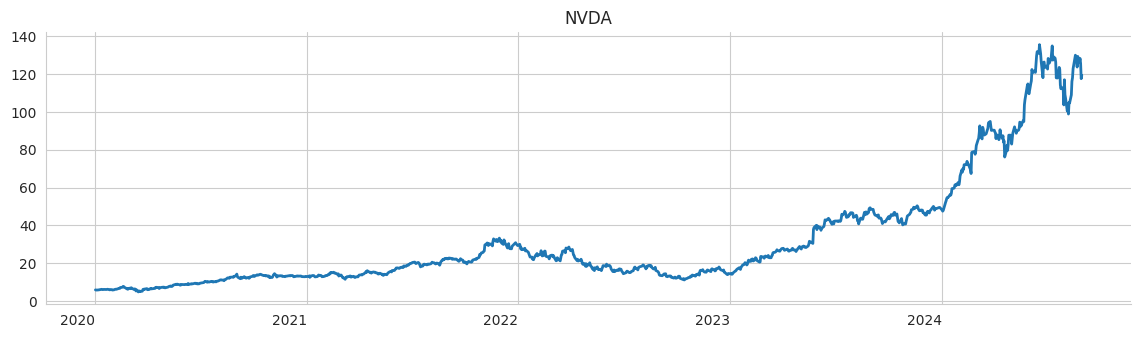

In [26]:
ax = stock_price.plot(title = stock_symbol, legend=False, linewidth = 2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [27]:
scaler = MinMaxScaler()
stocks_scaled = pd.Series(scaler.fit_transform(stock_price.values.reshape(-1, 1)).squeeze(), index=stock_price.index)

In [28]:
def create_univariate_lstm_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1)  # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

window_size = 60
X, y = create_univariate_lstm_data(stocks_scaled, window_size=window_size)

In [29]:
X_train = X[:'2022'].values.reshape(-1, window_size, 1)
y_train = y[:'2022']
X_test = X['2023':].values.reshape(-1, window_size, 1)
y_test = y['2023':]

In [30]:
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape, return_sequences=False, activation=activation[3]))
    model.add(Dense(units=dense_units, activation=activation[0]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [31]:
lstm = create_LSTM(hidden_units=100, dense_units=1, input_shape=(window_size, 1), activation=['linear', 'relu', 'tanh', 'sigmoid'])
lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
LSTM_training = lstm.fit(X_train, 
                        y_train, 
                        epochs=80, 
                        batch_size=30, 
                        validation_data=(X_test, y_test), 
                        verbose=1
                    )

Epoch 1/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0065 - val_loss: 0.1620
Epoch 2/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0020 - val_loss: 0.1566
Epoch 3/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0019 - val_loss: 0.1441
Epoch 4/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0018 - val_loss: 0.1303
Epoch 5/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0015 - val_loss: 0.1084
Epoch 6/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0013 - val_loss: 0.0937
Epoch 7/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0011 - val_loss: 0.0820
Epoch 8/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 9.9050e-04 - val_loss: 0.0647
Epoch 9/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 8.7711e-04 - val_loss: 0.0680
Epoch 10/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 8.5740e-04 - val_loss: 0.0495
Epoch 11/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.6609e-04 - val_loss: 0.0381
Epoch 12/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/

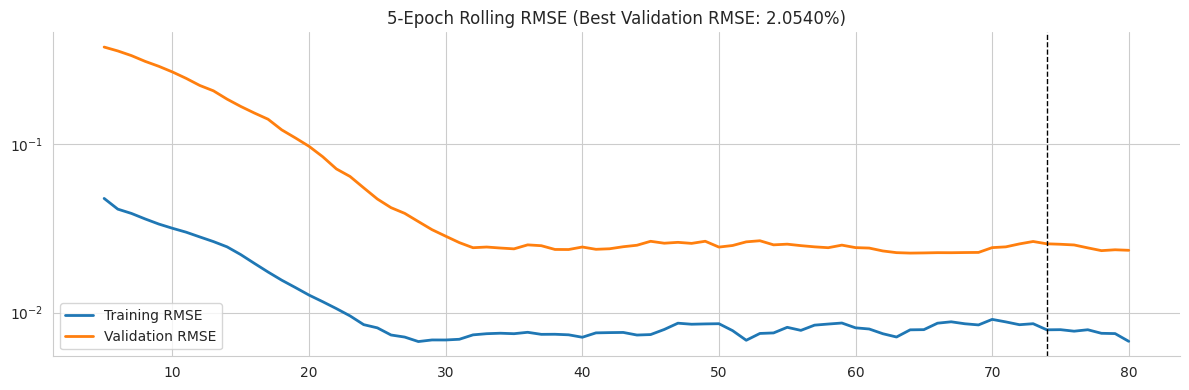

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(LSTM_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()

In [34]:
train_rmse_scaled = np.sqrt(lstm.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(lstm.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE (scaled): {train_rmse_scaled:.4f} | Test RMSE (scaled): {test_rmse_scaled:.4f}')

Train RMSE (scaled): 0.0118 | Test RMSE (scaled): 0.0280


In [35]:
train_predict_scaled = lstm.predict(X_train)
test_predict_scaled = lstm.predict(X_test)

train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f"Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Train IC: 0.9909 | Test IC: 0.9941


In [36]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))
# use inverse_transform to convert the scaled data back to its original scale.
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [37]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f"Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}")

Train RMSE: 1.54 | Test RMSE: 3.66


In [38]:
stock_price['Train Predictions'] = train_predict
stock_price['Test Predictions'] = test_predict

to_be_merged = pd.concat([train_predict.to_frame('predictions').assign(data='Train'),
                   test_predict.to_frame('predictions').assign(data='Test')])

stock_price = pd.merge(stock_price, to_be_merged, how='inner', on='Date')
stock_price.columns = stock_price.columns.str.rstrip('_x').str.rstrip('_y')

In [39]:
stock_price

,Adj Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2020-03-30,6.616442,4.917943,NaN,4.917943,Train
2020-03-31,6.566866,5.157372,NaN,5.157372,Train
2020-04-01,6.055418,5.181407,NaN,5.181407,Train
2020-04-02,6.364329,4.883157,NaN,4.883157,Train
2020-04-03,6.076344,5.057936,NaN,5.057936,Train
...,...,...,...,...,...
2024-08-26,126.449181,NaN,124.093056,124.093056,Test
2024-08-27,128.289032,NaN,122.767578,122.767578,Test
2024-08-28,125.599258,NaN,124.009674,124.009674,Test


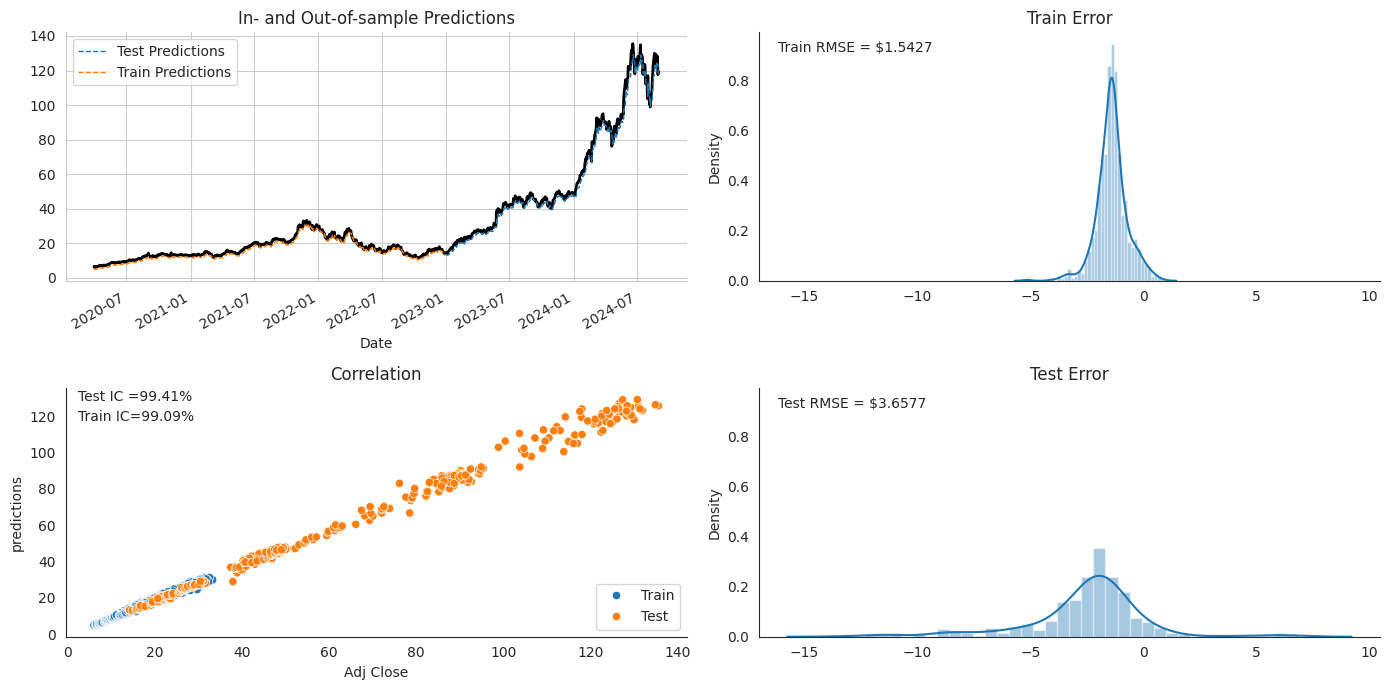

In [40]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)
stock_price.loc['2020':, price_type].plot(lw=2, ax=ax1, c='k')
stock_price.loc['2020':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x = price_type, y = 'predictions', data = stock_price, hue = 'data', ax = ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')

    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE = ${train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE = ${test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()